In [1]:
import sys
sys.path.append('..')
from jaewook_header import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
images=np.load('../../input/data1-L-images-conn.npy')
masks=np.load('../../input/data1-L-masks-conn.npy')

model_name='1201-unet-retry.h5'

IMG_HEIGHT,IMG_WIDTH=images.shape[1:3]
BATCH_SIZE=32

In [3]:
from sklearn.model_selection import train_test_split
images_train, images_val, masks_train, masks_val =\
train_test_split(images,masks,test_size=.1,random_state=seed)

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


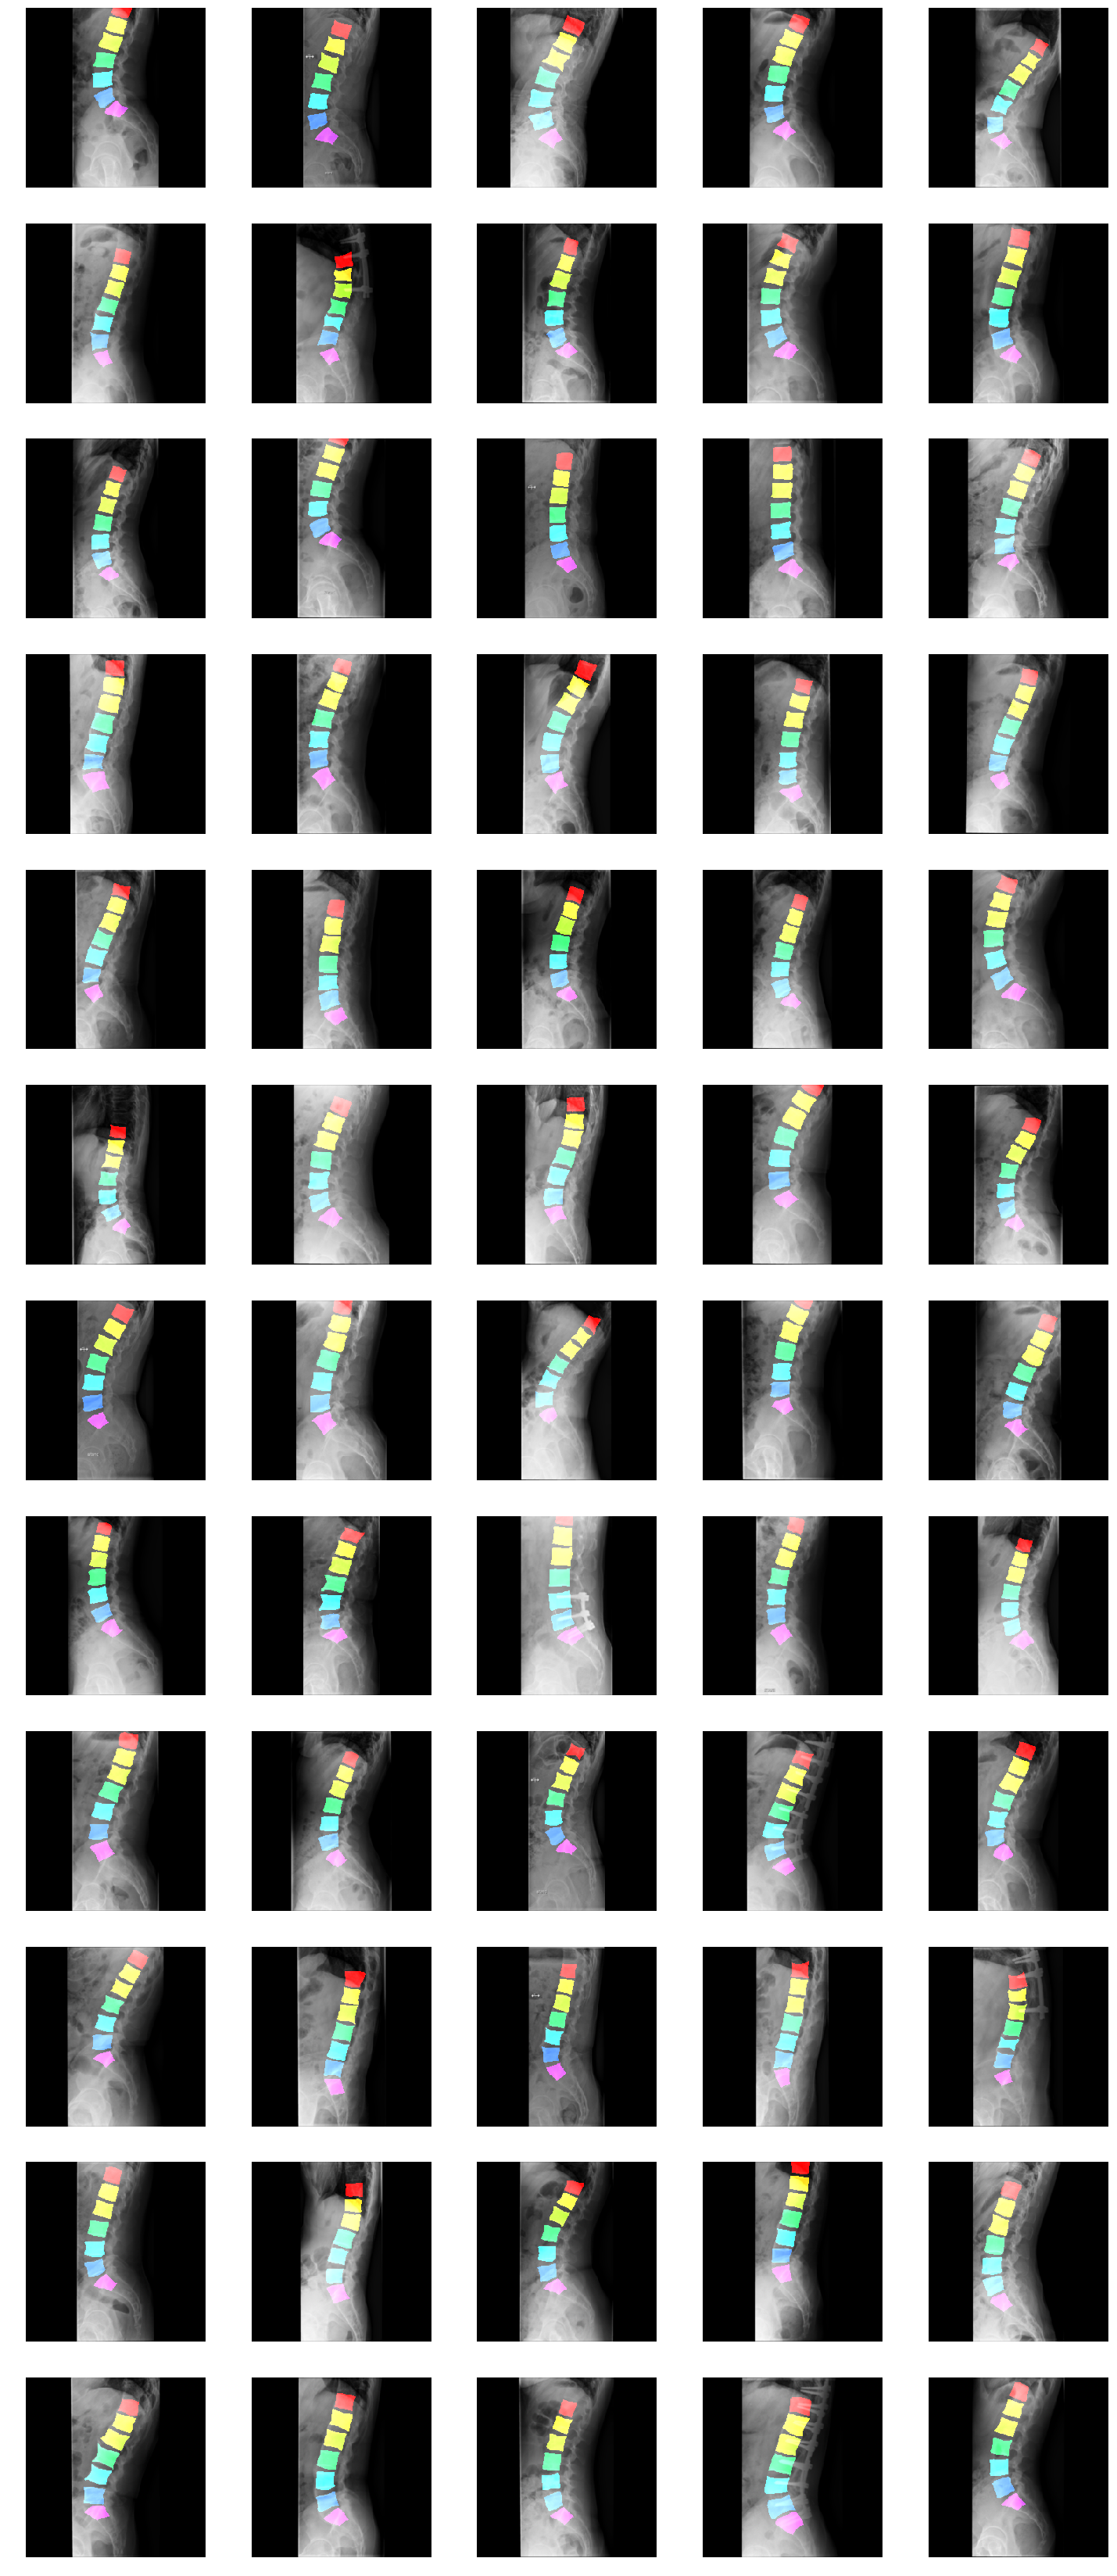

In [4]:
imshow2(overlay(images_train,level(masks_train)))

# Augmentation

In [5]:
data_gen_args=dict(rotation_range=45,
                   width_shift_range=.2,
                   height_shift_range=.2,
                   shear_range=.7,
                   zoom_range=[.9,2.2],
                   horizontal_flip=True,
                   fill_mode='constant')

# train

images_train_datagen=ImageDataGenerator(**data_gen_args)
masks_train_datagen=ImageDataGenerator(**data_gen_args)

images_train_generator=images_train_datagen.flow(images_train,
                                                 batch_size=BATCH_SIZE,
                                                 seed=seed)
masks_train_generator=masks_train_datagen.flow(masks_train,
                                               batch_size=BATCH_SIZE,
                                               seed=seed)

train_generator=zip(images_train_generator,masks_train_generator)

# validation

images_val_datagen=ImageDataGenerator()
masks_val_datagen=ImageDataGenerator()

images_val_generator=images_val_datagen.flow(images_val,seed=seed)
masks_val_generator=masks_val_datagen.flow(masks_val,seed=seed)

val_generator=zip(images_val_generator,masks_val_generator)

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\keras_preprocessing\image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (60, 256, 256, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\keras_preprocessing\image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (7, 256, 256, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


# Sanity Check

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


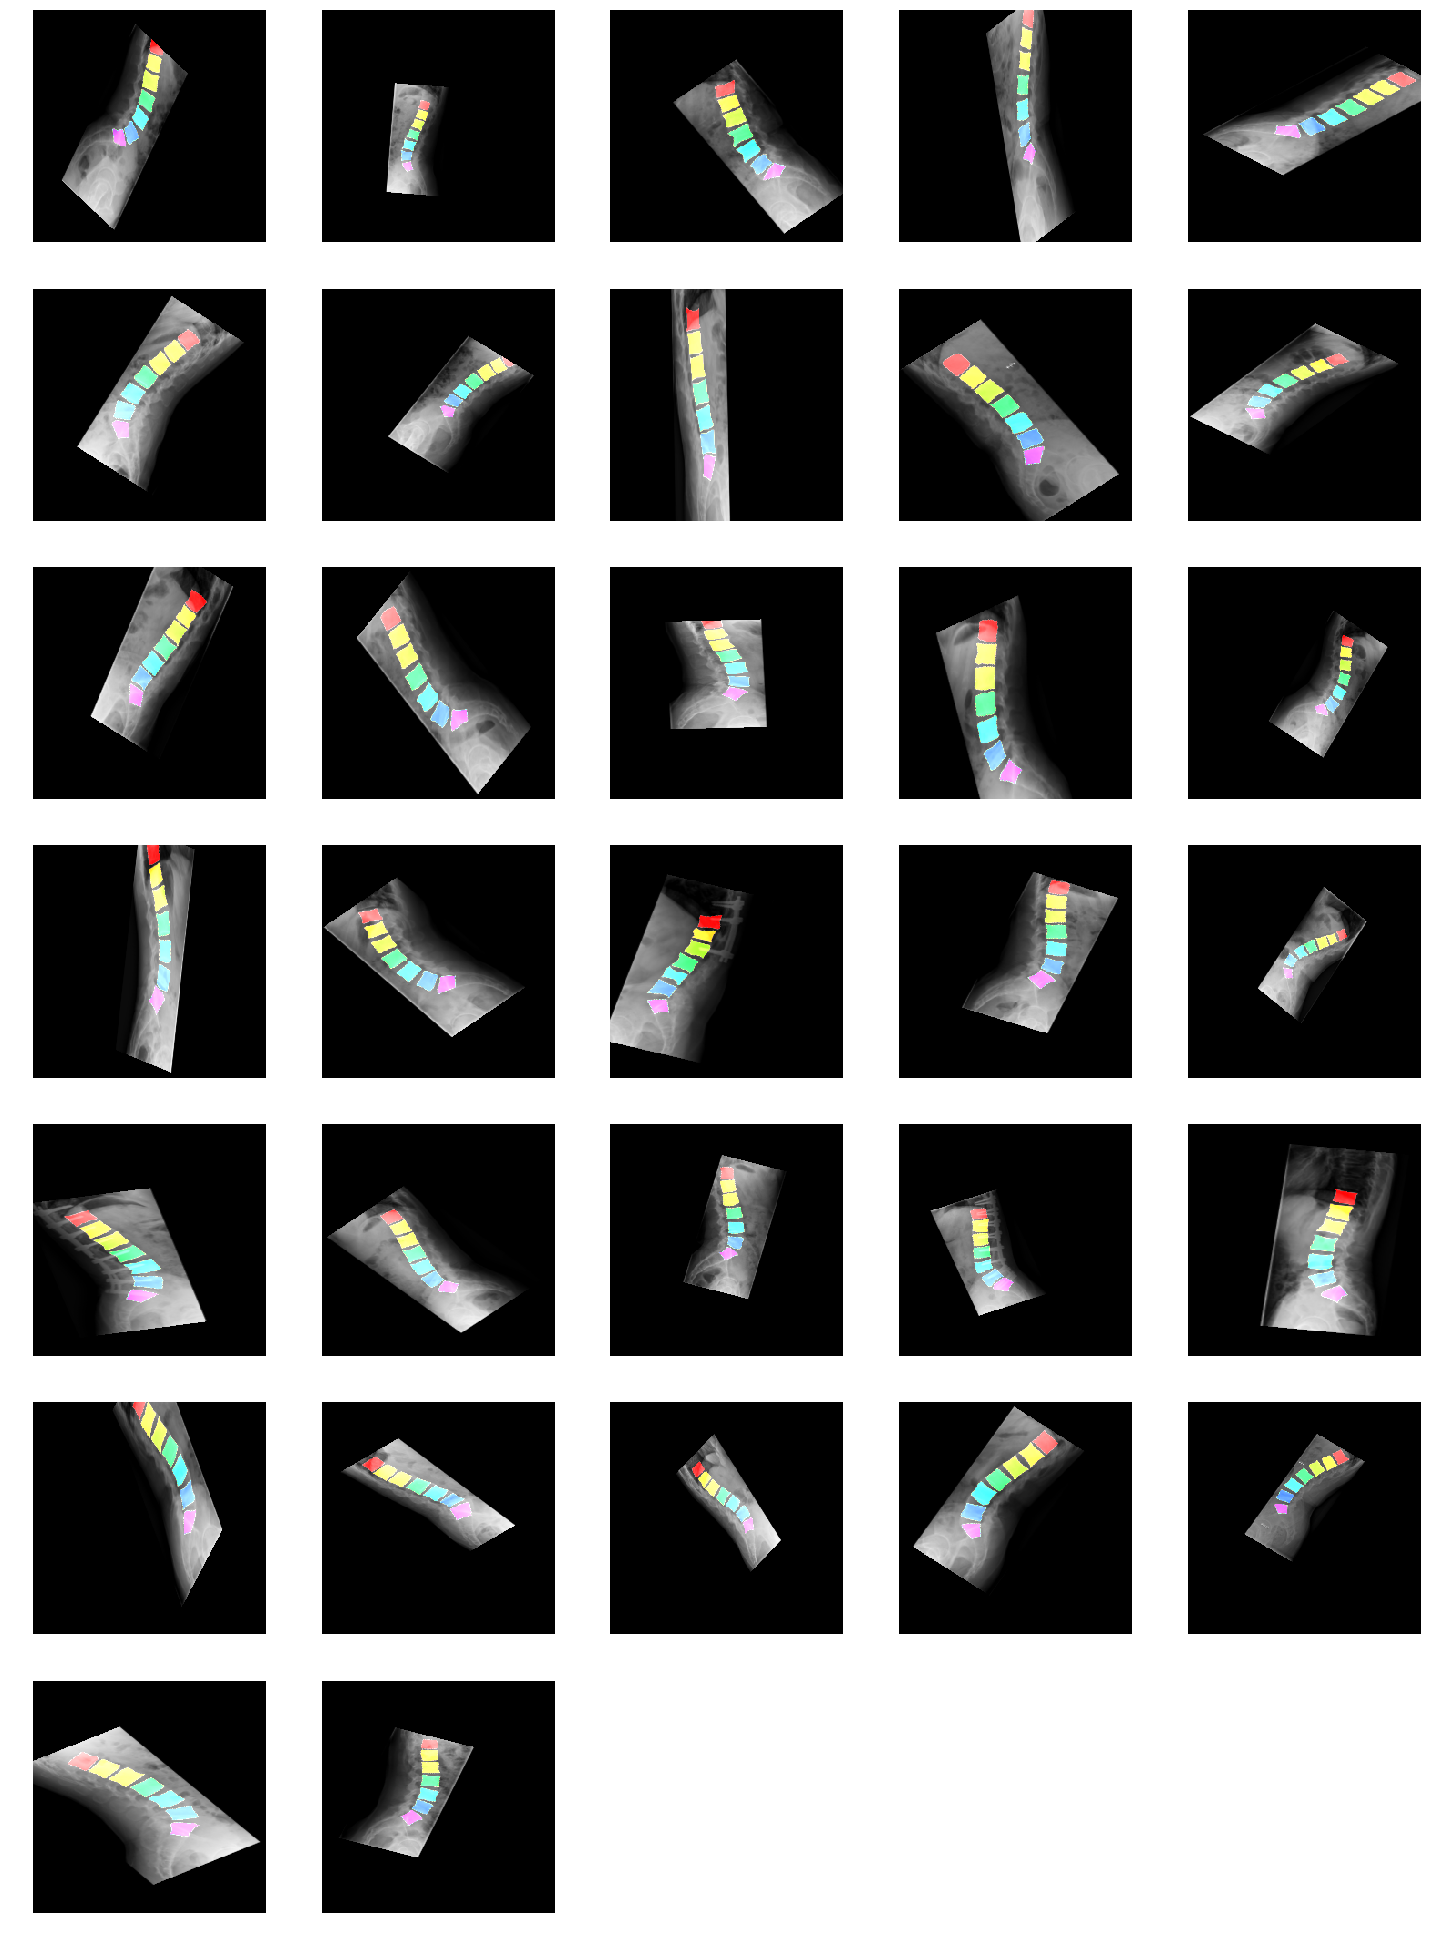

In [6]:
images_preview,masks_preview=next(train_generator)
imshow2(overlay(images_preview,level(masks_preview)))

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


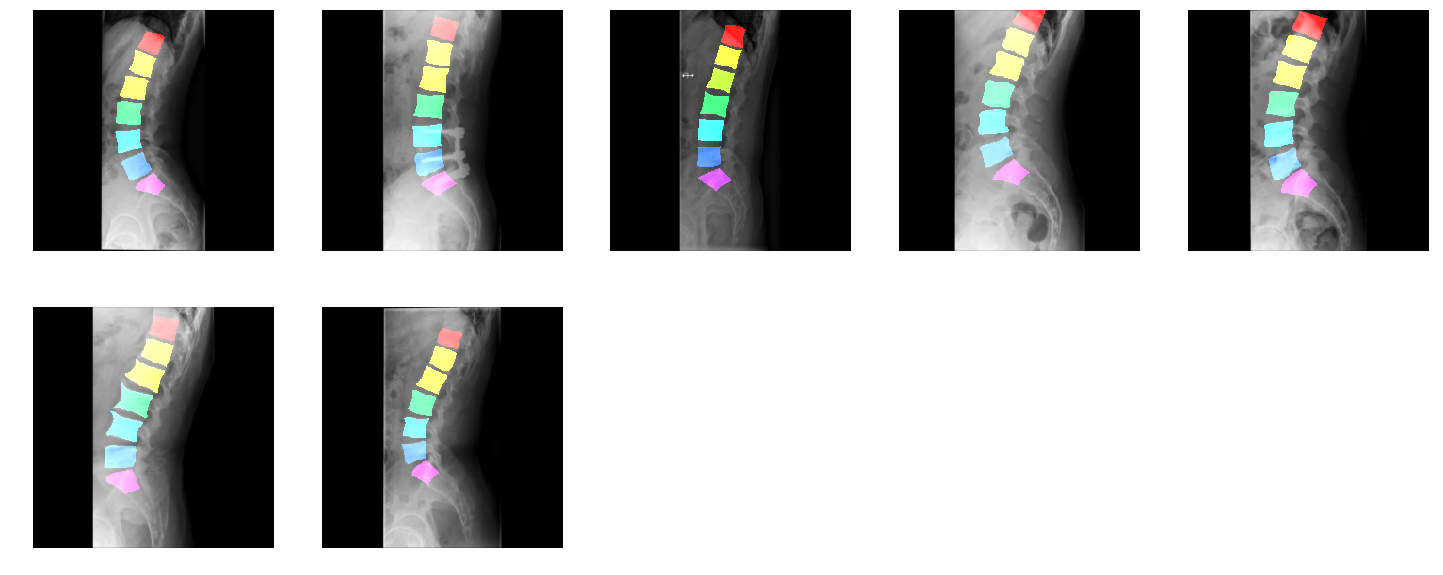

In [7]:
images_preview,masks_preview=next(val_generator)
imshow2(overlay(images_preview,level(masks_preview)))

In [8]:
# 남의 코드
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256, 256, 8)  5158472     lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

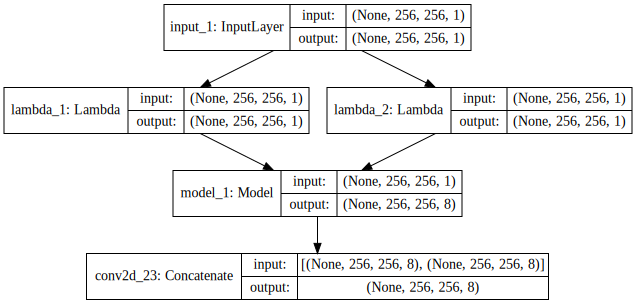

In [9]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
# s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization() (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c4m = BatchNormalization() (c4m)
c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4m)
p4m = MaxPooling2D(pool_size=(2, 2)) (c4m)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4m)
c5 = BatchNormalization() (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6m = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6m = concatenate([u6m, c4m])
c6m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6m)
c6m = BatchNormalization() (c6m)
c6m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6m)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6m)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(8, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model=multi_gpu_model(model,gpus=2)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
checkpointer = ModelCheckpoint(model_name,
                               monitor='val_mean_iou',
                               mode='max',
                               verbose=1,
                               save_best_only=True)

results=model.fit_generator(train_generator,
                            validation_data=val_generator,
                            validation_steps=1,
                            steps_per_epoch=100,
                            epochs=100,
                            callbacks=[checkpointer])

Epoch 1/100
100/100 [==============================] - 89s 887ms/step - loss: 0.2495 - mean_iou: 0.4699 - val_loss: 0.0891 - val_mean_iou: 0.4911

Epoch 00001: val_mean_iou improved from -inf to 0.49106, saving model to 1201-unet-retry.h5
Epoch 2/100
100/100 [==============================] - 82s 819ms/step - loss: 0.0284 - mean_iou: 0.4939 - val_loss: 0.0808 - val_mean_iou: 0.4962

Epoch 00002: val_mean_iou improved from 0.49106 to 0.49618, saving model to 1201-unet-retry.h5
Epoch 3/100
100/100 [==============================] - 82s 818ms/step - loss: 0.0183 - mean_iou: 0.5004 - val_loss: 0.0418 - val_mean_iou: 0.5059

Epoch 00003: val_mean_iou improved from 0.49618 to 0.50595, saving model to 1201-unet-retry.h5
Epoch 4/100
100/100 [==============================] - 82s 821ms/step - loss: 0.0156 - mean_iou: 0.5129 - val_loss: 0.0444 - val_mean_iou: 0.5205

Epoch 00004: val_mean_iou improved from 0.50595 to 0.52048, saving model to 1201-unet-retry.h5
Epoch 5/100
100/100 [==============

100/100 [==============================] - 82s 825ms/step - loss: 0.0020 - mean_iou: 0.7949 - val_loss: 0.0080 - val_mean_iou: 0.7967

Epoch 00035: val_mean_iou improved from 0.79311 to 0.79666, saving model to 1201-unet-retry.h5
Epoch 36/100
100/100 [==============================] - 82s 823ms/step - loss: 0.0020 - mean_iou: 0.7983 - val_loss: 0.0129 - val_mean_iou: 0.8000

Epoch 00036: val_mean_iou improved from 0.79666 to 0.80003, saving model to 1201-unet-retry.h5
Epoch 37/100
100/100 [==============================] - 82s 824ms/step - loss: 0.0026 - mean_iou: 0.8014 - val_loss: 0.0112 - val_mean_iou: 0.8028

Epoch 00037: val_mean_iou improved from 0.80003 to 0.80281, saving model to 1201-unet-retry.h5
Epoch 38/100
100/100 [==============================] - 82s 825ms/step - loss: 0.0022 - mean_iou: 0.8042 - val_loss: 0.0114 - val_mean_iou: 0.8057

Epoch 00038: val_mean_iou improved from 0.80281 to 0.80568, saving model to 1201-unet-retry.h5
Epoch 39/100
100/100 [===================

100/100 [==============================] - 82s 824ms/step - loss: 0.0016 - mean_iou: 0.8607 - val_loss: 0.0114 - val_mean_iou: 0.8613

Epoch 00069: val_mean_iou improved from 0.86013 to 0.86129, saving model to 1201-unet-retry.h5
Epoch 70/100
100/100 [==============================] - 82s 824ms/step - loss: 0.0016 - mean_iou: 0.8618 - val_loss: 0.0107 - val_mean_iou: 0.8624

Epoch 00070: val_mean_iou improved from 0.86129 to 0.86238, saving model to 1201-unet-retry.h5
Epoch 71/100
100/100 [==============================] - 82s 824ms/step - loss: 0.0018 - mean_iou: 0.8629 - val_loss: 0.0245 - val_mean_iou: 0.8634

Epoch 00071: val_mean_iou improved from 0.86238 to 0.86340, saving model to 1201-unet-retry.h5
Epoch 72/100
100/100 [==============================] - 82s 824ms/step - loss: 0.0016 - mean_iou: 0.8639 - val_loss: 0.0107 - val_mean_iou: 0.8644

Epoch 00072: val_mean_iou improved from 0.86340 to 0.86443, saving model to 1201-unet-retry.h5
Epoch 73/100
100/100 [===================

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


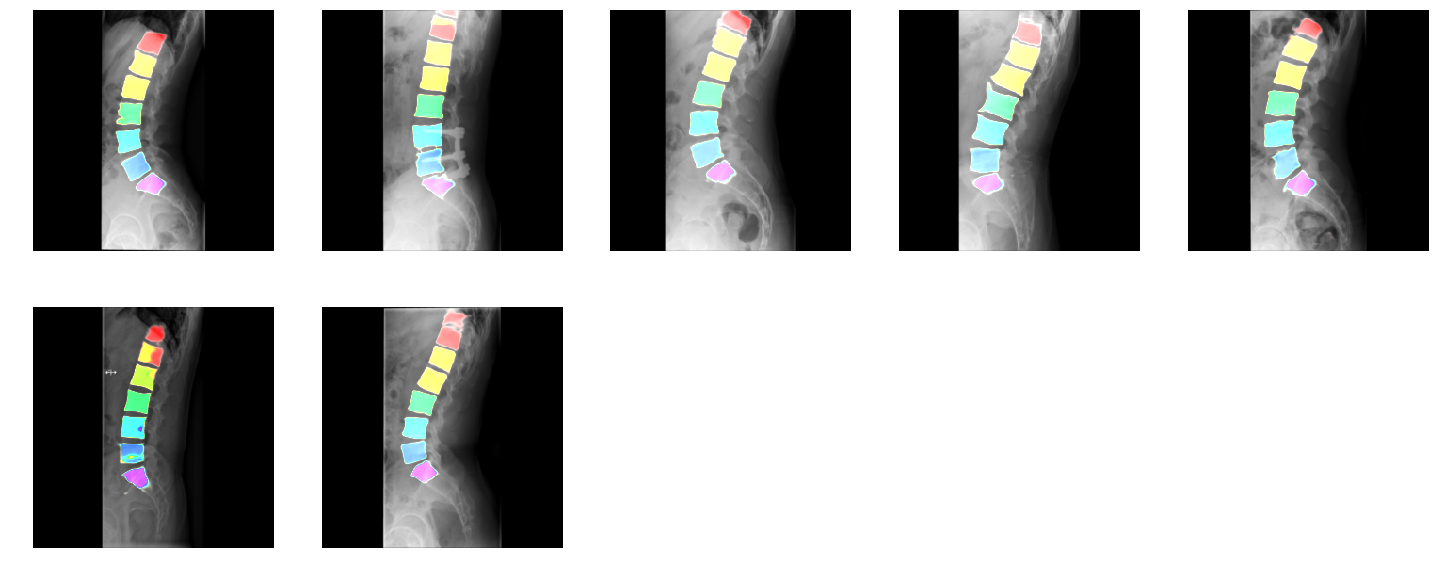

In [9]:
model=load_model(model_name,custom_objects={'mean_iou':mean_iou})
imshow2(overlay(images_val,level(model.predict(images_val))))

# 더 공부시키기

In [10]:
checkpointer = ModelCheckpoint('1201-unet-retry-study-more.h5',
                               monitor='val_mean_iou',
                               mode='max',
                               verbose=1,
                               save_best_only=True)

results=model.fit_generator(train_generator,
                            validation_data=val_generator,
                            validation_steps=1,
                            steps_per_epoch=100,
                            epochs=1000,
                            callbacks=[checkpointer])

Epoch 1/1000
100/100 [==============================] - 82s 820ms/step - loss: 0.0031 - mean_iou: 0.8730 - val_loss: 0.0090 - val_mean_iou: 0.9236

Epoch 00001: val_mean_iou improved from -inf to 0.92360, saving model to 1201-unet-retry-study-more.h5
Epoch 2/1000
100/100 [==============================] - 78s 784ms/step - loss: 0.0015 - mean_iou: 0.9300 - val_loss: 0.0087 - val_mean_iou: 0.9346

Epoch 00002: val_mean_iou improved from 0.92360 to 0.93457, saving model to 1201-unet-retry-study-more.h5
Epoch 3/1000
100/100 [==============================] - 78s 779ms/step - loss: 0.0015 - mean_iou: 0.9368 - val_loss: 0.0106 - val_mean_iou: 0.9385

Epoch 00003: val_mean_iou improved from 0.93457 to 0.93851, saving model to 1201-unet-retry-study-more.h5
Epoch 4/1000
100/100 [==============================] - 78s 779ms/step - loss: 0.0015 - mean_iou: 0.9397 - val_loss: 0.0110 - val_mean_iou: 0.9409

Epoch 00004: val_mean_iou improved from 0.93851 to 0.94086, saving model to 1201-unet-retry-s

KeyboardInterrupt: 

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


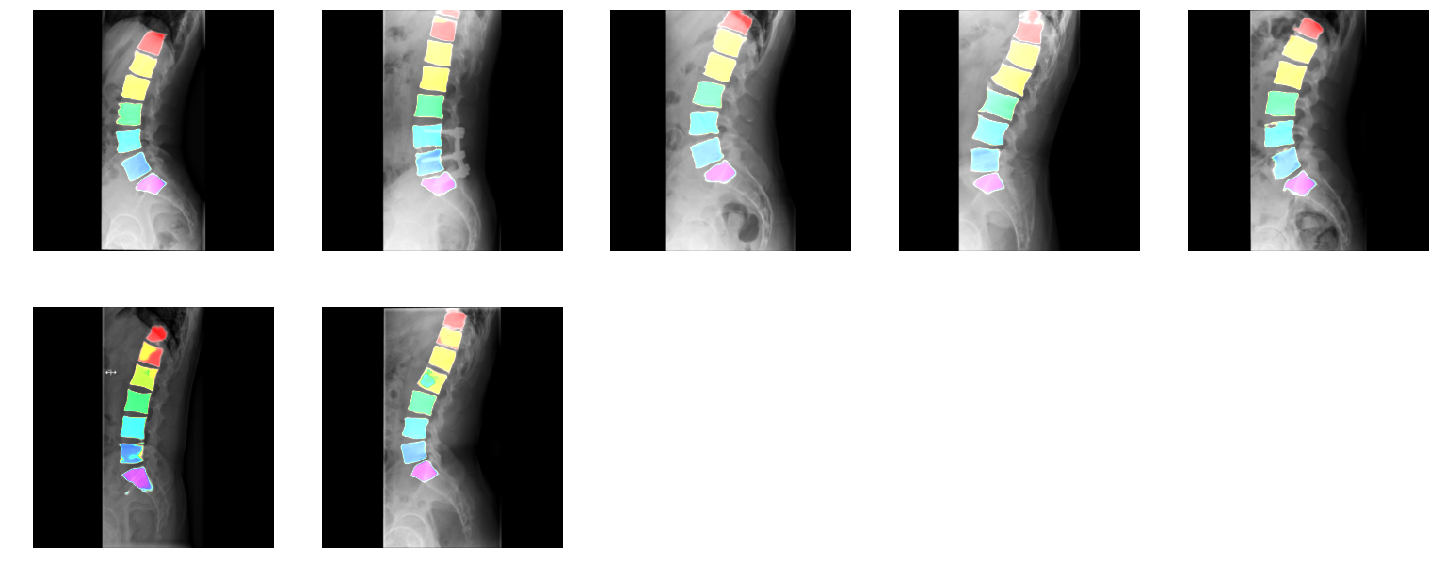

In [12]:
model=load_model('1201-unet-retry-study-more.h5',custom_objects={'mean_iou':mean_iou})
imshow2(overlay(images_val,level(model.predict(images_val))))

# L5만 배우도록 할수있나?

## RMSProp은 어떻지